## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [29]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os
import matplotlib.pyplot as plt

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [2]:
debar = pd.read_csv("debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
# Count the length of rows and then the number of employers
rows = len(debar)
employers = debar.Name.nunique()
difference = rows - employers
print(f"rows in dataframe: {rows}")
print(f"employers in dataframe: {employers}")
print(f"{difference} more rows than employers")
debar.Name.value_counts().head(20)

rows in dataframe: 114
employers in dataframe: 98
16 more rows than employers


Name
Maple Ridge Custom Services, LLC           2
Loewen Harvesting LLC                      2
Old Tree Farms/Verpaalen Custom Service    2
Dove Creek Farms                           2
Cisco Produce Inc.                         2
F&W Farms                                  2
Mark Duncan                                2
SRT Farms                                  2
Sharon Mathis                              2
Rollo Farm Labor Contractor                2
Turner Farms                               2
Caddo Creek Ranch, dba Paradise Ranch      2
Autumn Hill Orchard                        2
Annabella Land & Cattle                    2
Xavier Horne                               2
Macky and Brad Farms                       2
Landmark Landscaping                       1
M Keneston Corp                            1
Cira Cortez Lopez                          1
Labatte Farms                              1
Name: count, dtype: int64

There are 16 employers who are listed twice on the list. This could be because they were banned seperate times or they could be listed twice on accident

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [4]:
# Use duplicated function which will find duplicates in column for me
debar['is_repeated'] = debar.Name.duplicated(keep = False)

# B
debar[debar['is_repeated']]

# C
mult_debar = debar[debar['is_repeated']]
mult_debar.head()
mult_debar.shape

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AK",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

For every row that is "True" the company was either accidentally repeated in the dataset or they were banned multiple times. Since we are looking at just the name, it could be that a company has the same name but are from different places

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [5]:
fixer = mult_debar
# Cleaned State code and two companies -  fixed headquarter cities
fixer['City, State'] = fixer['City, State'].replace({
    'Utah'   : 'UT', 
    'Texas'  : 'TX', 
    'Georgia': 'GA', 
    'Brownsville, TX' : 'Brownfield, TX',
    'Altheimer, AK'   : 'Altheimer, AR'}, regex = True)

# Pivot Wider
mult_debar = fixer.groupby(['Name', 'City, State'])['Start date'].agg(['first', 'last']).reset_index()
mult_debar.columns = ['Name', 'City, State', 'start_date_viol1', 'start_date_viol2']

mult_debar.head()
mult_debar.shape

/var/folders/yq/ssgkp1wn2tbb4cflr_7nnmtr0000gn/T/ipykernel_82764/73034905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixer['City, State'] = fixer['City, State'].replace({


,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018


(16, 4)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [6]:
# Is dup dataframe subset
mult_debar['is_dup'] = mult_debar['start_date_viol1'] == mult_debar['start_date_viol2']
is_dup = mult_debar[['Name','City, State', 'is_dup']]
is_dup

# Clean city state names to match mult_debar
debar_clean = debar
debar_clean['City, State'] = debar_clean['City, State'].replace({
    'Utah'   : 'UT', 
    'Texas'  : 'TX', 
    'Georgia': 'GA', 
    'Brownsville, TX' : 'Brownfield, TX',
    'Altheimer, AK'   : 'Altheimer, AR'}, regex = True)

# Merge and then use is_dup to drop duplicates
debar_clean = debar_clean.merge(is_dup, left_on = ['Name', 'City, State'], right_on = ['Name', 'City, State'], how = "left")
debar_clean = debar_clean[~(debar_clean[['Name', 'City, State']].duplicated(keep='first') & debar_clean['is_dup'])]
len(debar_clean)
# Remove column
debar = debar.drop('is_repeated', axis = 1)



,Name,"City, State",is_dup
0,Annabella Land & Cattle,"Annabella, UT",True
1,Autumn Hill Orchard,"Groton, MA",True
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",True
3,Cisco Produce Inc.,"Cairo, GA",False
4,Dove Creek Farms,"Mount Vernon, TX",True
5,F&W Farms,"Ingalls, KS",True
6,Loewen Harvesting LLC,"Brownfield, TX",True
7,Macky and Brad Farms,"Plains, TX",True
8,"Maple Ridge Custom Services, LLC","Altheimer, AR",True
9,Mark Duncan,"Roosevelt, UT",True


101

The original dataframe is 114 rows. We found 16 companies repeated in the dataset. If each one was actually a duplicate we would clean to have only 98 rows. The three falses we print out above are not duplicates which would get us to 101 rows. However, Loewen Harvesting LLC and Maple Ridge Custom Services are not duplicates becasue they are from differnt city, States so they need to be kept as well. This would result us in a length of 105 rows.

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [7]:
jobs = pd.read_csv("jobs.csv")

jobs.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [8]:
# Find Matches
matches = jobs.merge(debar_clean, left_on ="EMPLOYER_NAME", right_on = "Name", how = "inner")
# Print Matches
print(matches)

          CASE_NUMBER                           CASE_STATUS  \
0  H-300-20287-876656  Determination Issued - Certification   

             RECEIVED_DATE            DECISION_DATE  \
0  2020-10-20 09:20:32.010  2020-11-09 00:00:00.000   

  TYPE_OF_EMPLOYER_APPLICATION H2A_LABOR_CONTRACTOR NATURE_OF_TEMPORARY_NEED  \
0          Individual Employer                    Y                 Seasonal   

  EMERGENCY_FILING   EMPLOYER_NAME TRADE_NAME_DBA  ...  \
0                Y  Rafael Barajas            NaN  ...   

                WEBSITE_TO_APPLY TOTAL_ADDENDUM_A_RECORDS            Name  \
0  https://seasonaljobs.dol.gov/                        7  Rafael Barajas   

        City, State                         Violation Duration Start date  \
0  Sebring, Florida  Non-payment of certification fee   1 year  9/23/2016   

    End date  is_repeated  is_dup  
0  9/22/2017        False     NaN  

[1 rows x 146 columns]


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [9]:
jobsdf = jobs

# Use list comeprehension to overwrite values in debar_celean and jobsdf
jobsdf['EMPLOYER_NAME'] = [name.upper() for name in jobsdf['EMPLOYER_NAME']]
debar_clean['Name'] = [name.upper() for name in debar_clean['Name']]

In [10]:
# B
jobsdf.EMPLOYER_NAME.sample(15)
debar_clean.Name.sample(15)

384                                SUN BERRY ORCHARD INC.
1354                               WAGNER GREENHOUSES INC
460                                       TRI BENOIT, LLC
2649                                   THOMAS BROS. GRASS
1367                                   LUDIVINA MARTINEZ 
1903                                     PINE POINT FARMS
1706                               LIONEL MOUNIER JR FARM
1943                                       WONDERFUL BEES
2080                                HIGH COUNTRY LAMB LLC
2145                    MEADOWOOD FARMS OF CAZENOVIA, LLC
1599                    FAULKNER LAND & LIVESTOCK COMPANY
1453                            HILLSIDE GARDENS USA, INC
1156    LOEWER BROTHERS (MICAH, CLINTON, JAMES & PAUL ...
1797                               THE PURPLE SAGE RANCH 
1840                               C & J SMITH FARMS, LLC
Name: EMPLOYER_NAME, dtype: object

100                       EVERGREEN PRODUCE
67                           ROSALVA GARCIA
12              ROLLO FARM LABOR CONTRACTOR
49            CITY PINESTRAW AND HARVESTING
57                            DIXIE BELL #2
13                            REIMER'S INC.
32                   FIRST AMERICAN HOLDING
37                             JOHN R. COOK
103                        DOVE CREEK FARMS
27                   YOLANDA CHAVEZ FARMING
83                        CIRA CORTEZ LOPEZ
11                    LOEWEN HARVESTING LLC
50                           E.V. RANCH LLP
85            TRINITY LIVESTOCK PARTNERSHIP
74     JIM AND ANN SHIPLEY WILLIAM SHIPLEY*
Name: Name, dtype: object

In [11]:
## insert your code for assigning the uppercase names back to the data

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [12]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP."

In [13]:
## insert your code here with the regex pattern for part A
list1 = [pos_example_1, pos_example_2, neg_example]
pattern = r'(LLC|CO|INC)\.'

## insert your code to use re.sub to apply the pattern to the test cases for part B
testPattern = [re.sub(pattern, r'\1', name) 
                    for name in list1] 
testPattern

['CISCO PRODUCE INC', 'AVOYELLES HONEY CO, LLC', 'E.V. RANCH LLP.']

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [14]:
# Add column in debar_clean
name_clean = [re.sub(pattern, r'\1', name) 
                    for name in debar_clean.Name]
debar_clean['name_clean'] = name_clean

#Add column in jobsdf
jobname_clean = [re.sub(pattern, r'\1', name) 
                    for name in jobsdf.EMPLOYER_NAME]
jobsdf['name_clean'] = jobname_clean

In [15]:
# Subset
debar_clean[~(debar_clean['Name'] == debar_clean['name_clean'])][['Name', 'name_clean']]
# Subset
jobsdf[~(jobsdf['EMPLOYER_NAME'] == jobsdf['name_clean'])][['EMPLOYER_NAME', 'name_clean']]

,Name,name_clean
3,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
5,PROMAX INC.,PROMAX INC
13,REIMER'S INC.,REIMER'S INC
19,CISCO PRODUCE INC.,CISCO PRODUCE INC
23,REIMER’S INC.,REIMER’S INC
33,GERONIMO SHEEP CO.,GERONIMO SHEEP CO
46,ALTENDORF TRANSPORT INC.,ALTENDORF TRANSPORT INC
56,CISCO PRODUCE INC.,CISCO PRODUCE INC
72,"SAXTONS RIVER ORCHARDS, INC.","SAXTONS RIVER ORCHARDS, INC"


,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"
...,...,...
2700,HARRAL LIVESTOCK CO. LLC,HARRAL LIVESTOCK CO LLC
2701,ECOSYSTEM CONCEPTS INC.,ECOSYSTEM CONCEPTS INC
2702,SIDDOWAY SHEEP CO.,SIDDOWAY SHEEP CO
2705,SATHER MANAGEMENT INC.,SATHER MANAGEMENT INC


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [16]:
# A 
# Merge 
merging2 = jobsdf.merge(debar_clean, left_on="name_clean", right_on="name_clean", how = "inner")
merging2

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_ADDENDUM_A_RECORDS,name_clean,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,is_dup
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,7,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,False,NaN


In [17]:
# B - Testing regex patterns
pattern2 = r'\.|\.\s*|(\s*LLP\s*)|LLP$'
tester = "SLASH E.V. RANCH LLP" 
tester2 = "Just Play.Ing LLP Around"

list0 = [tester, tester2]

# Use re.sub() to replace matched patterns with an empty string
testing = [re.sub(pattern2, '', name) 
                    for name in list0]
testing


['SLASH EV RANCH', 'Just PlayIngAround']

In [18]:
# Using Code for name_clean_2
pattern2 = r'\.|\.\s*|(\s*LLP\s*)|LLP$'

name_clean_2 = [re.sub(pattern2, '', name) 
                    for name in debar_clean.name_clean]
debar_clean['name_clean_2'] = name_clean_2
debar_clean

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,is_dup,name_clean,name_clean_2
0,J&J HARVESTING,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016,False,NaN,J&J HARVESTING,J&J HARVESTING
1,"STAHLMAN APIARIES, INC","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016,False,NaN,"STAHLMAN APIARIES, INC","STAHLMAN APIARIES, INC"
2,TRUST NURSERY,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015,False,NaN,TRUST NURSERY,TRUST NURSERY
3,ANTON FERTILIZER INC.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False,NaN,ANTON FERTILIZER INC,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False,NaN,"GREAT PLAINS FLUID SERVICE, INC","GREAT PLAINS FLUID SERVICE, INC"
...,...,...,...,...,...,...,...,...,...,...
107,WALKER PLACE,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020,False,NaN,WALKER PLACE,WALKER PLACE
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020,False,NaN,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...
110,JESUS LEDESMA,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20,False,NaN,JESUS LEDESMA,JESUS LEDESMA
112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),"Collins, GA",WHD Debarment,3 years,4/9/17,4/9/20,False,NaN,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)


In [19]:
# Left Join
leftjoinMerge = jobsdf.merge(debar_clean, left_on= "name_clean", right_on = "name_clean_2", how = "inner")
leftjoinMerge

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,is_dup,name_clean_y,name_clean_2
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,False,NaN,RAFAEL BARAJAS,RAFAEL BARAJAS
1,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,False,NaN,SLASH E.V. RANCH LLP,SLASH EV RANCH


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [20]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

# Pattern
pattern = r'^(.*?) \(COMPANY\).*?AND (.*?) \(INDIVIDUAL\)'

# Positive 
posMatch = re.findall(pattern, pos_example)
posMatch

## Negative
negMatch = re.findall(pattern, neg_example)
negMatch

[('COUNTY FAIR FARM', 'ANDREW WILLIAMSON')]

[]

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [26]:
# Create lists
co_names = []
ind_names = []

# Name_clean in debar clean
for name_clean in debar_clean['name_clean']:
    matches = re.findall(pattern, name_clean)
    
    if matches:
        company_name, individual_name = matches[0]
        
        co_names.append(company_name.strip()) 
        ind_names.append(individual_name.strip()) 
    else:
        co_names.append(name_clean)
        ind_names.append(name_clean)

# Add columns
debar_clean['co_name'] = co_names
debar_clean['ind_name'] = ind_names

debar_clean[['ind_name', 'co_name']]
debar_clean[debar_clean['ind_name']!= debar_clean['co_name']]

,ind_name,co_name
0,J&J HARVESTING,J&J HARVESTING
1,"STAHLMAN APIARIES, INC","STAHLMAN APIARIES, INC"
2,TRUST NURSERY,TRUST NURSERY
3,ANTON FERTILIZER INC,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC","GREAT PLAINS FLUID SERVICE, INC"
...,...,...
107,WALKER PLACE,WALKER PLACE
108,ANDREW WILLIAMSON,COUNTY FAIR FARM
110,JESUS LEDESMA,JESUS LEDESMA
112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,is_dup,name_clean,name_clean_2,co_name,ind_name
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020,False,NaN,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON


   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [28]:
# Positive 
positive_rows = debar_clean[debar_clean['name_clean'].str.contains('WILLIAMSON', case=False, na=False)]

# Positve example
positive_rows[['name_clean', 'co_name', 'ind_name', 'Violation']]

# Negative example
negative_rows = debar_clean[debar_clean['name_clean'].str.contains(neg_example, case=False, na=False)]

negative_rows[['name_clean', 'co_name', 'ind_name', 'Violation']]

,name_clean,co_name,ind_name,Violation
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


,name_clean,co_name,ind_name,Violation
19,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
56,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Axes: xlabel='Start date'>

Text(0.5, 1.0, 'Violations of Guestworker rights from 2013 - 2019')

Text(0.5, 0, 'Year')

Text(0, 0.5, '# of Violations')

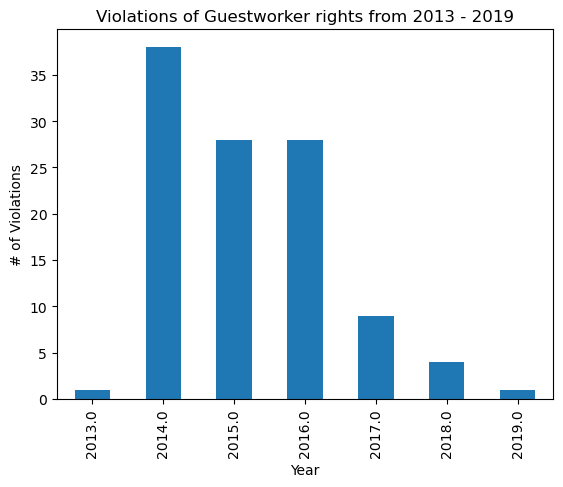

In [32]:
# Start date to date time
debar['Start date'] = pd.to_datetime(debar['Start date'], errors='coerce')

# Count by year
violations_per_year = debar.groupby(debar['Start date'].dt.year).size()

# Plot and label
violations_per_year.plot(kind='bar')
plt.title('Violations of Guestworker rights from 2013 - 2019')
plt.xlabel('Year')
plt.ylabel('# of Violations')
plt.show()